In [1]:
!jupyter nbextension enable --py widgetsnbextension

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")


In [3]:
from pyspark.sql import SparkSession


spark = SparkSession.builder \
.appName('crime_analytics') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.sql.autoBroadcastJoinThreshold', "3000") \
.config('spark.driver.memory','110G') \
.config('spark.sql.repl.eagerEval.enabled', True) \
.config("spark.driver.maxResultSize", "200g") \
.config("spark.memory.fraction", "0.95") \
.config("spark.memory.storageFraction", "0.5")\
.config("spark.sql.shuffle.partitions", "50")\
.config("spark.memory.offHeap.enabled", "false")\
.config("spark.reducer.maxSizeInFlight", "50m")\
.config("spark.shuffle.file.buffer", "1m")\
.config("spark.sql.broadcastTimeout", "300")\
.config("spark.default.parallelism", "1000")\
.config("shuffle.partitions",100)\
.getOrCreate()

# my_dataframe = pd.read_csv("", header = True)
merged_csv = spark.read.format("csv").option("header", "true").load("../all.csv")
(merged_csv).show(vertical=True)

/usr/bin/hadoop


/etc/profile.d/perlbin.sh: line 5: append_path: command not found
/etc/profile.d/perlbin.sh: line 7: append_path: command not found
/etc/profile.d/perlbin.sh: line 9: append_path: command not found
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/apache-spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop-3.3.2/share/hadoop/common/lib/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-04 17:07:20,135 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


-RECORD 0-------------------------------------
 Crime ID              | null                 
 Month                 | 2010-12              
 Reported by           | Avon and Somerset... 
 Falls within          | Avon and Somerset... 
 Longitude             | -0.805600            
 Latitude              | 51.819143            
 Location              | On or near Norfol... 
 LSOA code             | E01017662            
 LSOA name             | Aylesbury Vale 015C  
 Crime type            | Other crime          
 Last outcome category | null                 
 Context               | null                 
-RECORD 1-------------------------------------
 Crime ID              | null                 
 Month                 | 2010-12              
 Reported by           | Avon and Somerset... 
 Falls within          | Avon and Somerset... 
 Longitude             | -2.494366            
 Latitude              | 51.418169            
 Location              | On or near Keynsh... 
 LSOA code   

In [4]:
merged_csv = merged_csv.drop('Context','LSOA code','LSOA name','Latitude','Longitude','Reported by','Crime ID')

schema = merged_csv.schema ## Displaying the schema
print(schema)

StructType(List(StructField(Month,StringType,true),StructField(Falls within,StringType,true),StructField(Location,StringType,true),StructField(Crime type,StringType,true),StructField(Last outcome category,StringType,true)))


In [5]:
pandas_data = merged_csv.toPandas()
pandas_data

,Month,Falls within,Location,Crime type,Last outcome category
0,2010-12,Avon and Somerset Constabulary,On or near Norfolk Terrace,Other crime,None
1,2010-12,Avon and Somerset Constabulary,On or near Keynsham Road,Anti-social behaviour,None
2,2010-12,Avon and Somerset Constabulary,On or near Harlech Close,Anti-social behaviour,None
3,2010-12,Avon and Somerset Constabulary,On or near Orchard Close,Anti-social behaviour,None
4,2010-12,Avon and Somerset Constabulary,On or near Harlech Close,Anti-social behaviour,None
...,...,...,...,...,...
68673311,2021-12,Wiltshire Police,On or near Petrol Station,Shoplifting,Under investigation
68673312,2021-12,Wiltshire Police,On or near Church Hatch,Vehicle crime,Investigation complete; no suspect identified
68673313,2021-12,Wiltshire Police,On or near Hamilton Park,Vehicle crime,Investigation complete; no suspect identified
68673314,2021-12,Wiltshire Police,On or near The Headlands,Violence and sexual offences,Under investigation


## Wiltshire County

In [7]:
wilt = pandas_data.loc[pandas_data['Falls within'] == "Wiltshire Police"]

wilt

,Month,Falls within,Location,Crime type,Last outcome category
470046,2010-12,Wiltshire Police,On or near Station Road,Other crime,None
470047,2010-12,Wiltshire Police,On or near Thames Street,Anti-social behaviour,None
470048,2010-12,Wiltshire Police,On or near Downs View,Anti-social behaviour,None
470049,2010-12,Wiltshire Police,On or near Westrop,Anti-social behaviour,None
470050,2010-12,Wiltshire Police,On or near St. Michaels Avenue,Anti-social behaviour,None
...,...,...,...,...,...
68673311,2021-12,Wiltshire Police,On or near Petrol Station,Shoplifting,Under investigation
68673312,2021-12,Wiltshire Police,On or near Church Hatch,Vehicle crime,Investigation complete; no suspect identified
68673313,2021-12,Wiltshire Police,On or near Hamilton Park,Vehicle crime,Investigation complete; no suspect identified
68673314,2021-12,Wiltshire Police,On or near The Headlands,Violence and sexual offences,Under investigation


In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(wilt, title="Wiltshire Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
## Month and the number of crimes committed in wiltshire

wilt_crime_count = wilt.groupby(["Month"]).size()
wilt_crime_count_reset = wilt_crime_count.reset_index()
wilt_crime_count_reset.rename(columns = {0:'Count'}, inplace = True)

wilt_crime_count_reset['Month'] = pd.to_datetime(wilt_crime_count_reset['Month'])

wilt_analytics = wilt_crime_count_reset.groupby(by = "Month").Count.mean()
wilt_analytics

Month
2010-12-01    4338.0
2011-01-01    4510.0
2011-02-01    4746.0
2011-03-01    2772.0
2011-04-01    5762.0
               ...  
2021-08-01    4650.0
2021-09-01    4807.0
2021-10-01    4637.0
2021-11-01    4565.0
2021-12-01    4168.0
Name: Count, Length: 133, dtype: float64

<AxesSubplot:title={'center':'Number of Crimes each month'}, xlabel='Month'>

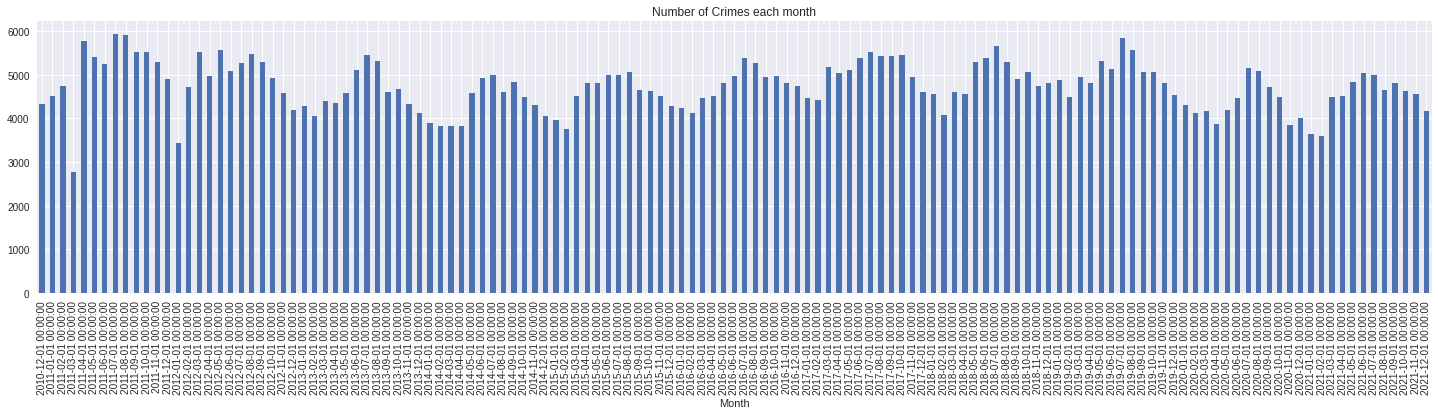

In [9]:
wilt_analytics.plot(kind= "bar",  figsize=(25, 5), title= "Number of Crimes each month")

In [10]:
from darts import TimeSeries

series = TimeSeries.from_series(wilt_analytics)

series

<TimeSeries (DataArray) (Month: 133, component: 1, sample: 1)>
array([[[4338.]],

       [[4510.]],

       [[4746.]],

       [[2772.]],

       [[5762.]],

       [[5411.]],

       [[5247.]],

       [[5927.]],

       [[5912.]],

       [[5525.]],

...

       [[4486.]],

       [[4514.]],

       [[4839.]],

       [[5044.]],

       [[5004.]],

       [[4650.]],

       [[4807.]],

       [[4637.]],

       [[4565.]],

       [[4168.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 2010-12-01 2011-01-01 ... 2021-12-01
  * component  (component) object 'Count'
Dimensions without coordinates: sample

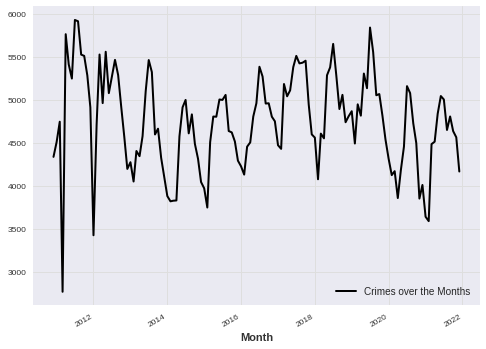

In [11]:
series.plot(label="Crimes over the Months")

In [13]:
train, val = series[:-20], series[-30:]
val

<TimeSeries (DataArray) (Month: 30, component: 1, sample: 1)>
array([[[5839.]],

       [[5554.]],

       [[5053.]],

       [[5067.]],

       [[4815.]],

       [[4540.]],

       [[4317.]],

       [[4126.]],

       [[4172.]],

       [[3860.]],

...

       [[4486.]],

       [[4514.]],

       [[4839.]],

       [[5044.]],

       [[5004.]],

       [[4650.]],

       [[4807.]],

       [[4637.]],

       [[4565.]],

       [[4168.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 2019-07-01 2019-08-01 ... 2021-12-01
  * component  (component) object 'Count'
Dimensions without coordinates: sample

In [14]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

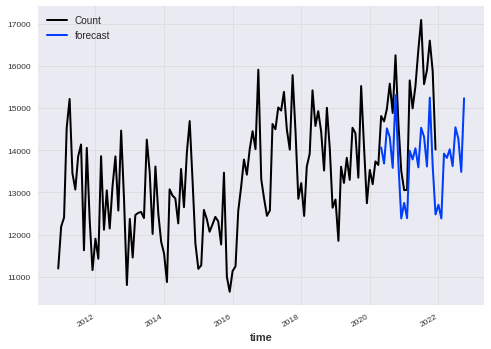

In [51]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.5, high_quantile=0.5)
plt.legend()

## Manchester County

In [52]:
manchester = pandas_data.loc[pandas_data['Falls within'] == "Greater Manchester Police"]
manchester

,Month,Falls within,Location,Crime type,Last outcome category
86372,2010-12,Greater Manchester Police,On or near Birches Road,Anti-social behaviour,None
86373,2010-12,Greater Manchester Police,On or near Belmont Road,Anti-social behaviour,None
86374,2010-12,Greater Manchester Police,On or near Belmont Road,Burglary,None
86375,2010-12,Greater Manchester Police,On or near Threlkeld Road,Vehicle crime,None
86376,2010-12,Greater Manchester Police,On or near Belmont Road,Vehicle crime,None
...,...,...,...,...,...
52668731,2019-06,Greater Manchester Police,On or near Fulwood Road,Burglary,Investigation complete; no suspect identified
52668732,2019-06,Greater Manchester Police,On or near Elcombe Avenue,Vehicle crime,Investigation complete; no suspect identified
52668733,2019-06,Greater Manchester Police,On or near Craven Avenue,Violence and sexual offences,Unable to prosecute suspect
52668734,2019-06,Greater Manchester Police,On or near Norwood Avenue,Violence and sexual offences,Investigation complete; no suspect identified


In [19]:
manchester_crime_count = manchester.groupby(["Month"]).size()
manchester_crime_count_reset = manchester_crime_count.reset_index()
manchester_crime_count_reset.rename(columns = {0:'Count'}, inplace = True)

manchester_crime_count_reset['Month'] = pd.to_datetime(manchester_crime_count_reset['Month'])

manchester_analytics = manchester_crime_count_reset.groupby(by = "Month").Count.mean()
manchester_analytics

Month
2010-12-01    25968.0
2011-01-01    29267.0
2011-02-01    28319.0
2011-03-01    32842.0
2011-04-01    32551.0
               ...   
2019-02-01    30117.0
2019-03-01    33936.0
2019-04-01    32703.0
2019-05-01    33386.0
2019-06-01    32058.0
Name: Count, Length: 103, dtype: float64

Month
2010-12-01    25968.0
2011-01-01    29267.0
2011-02-01    28319.0
2011-03-01    32842.0
2011-04-01    32551.0
               ...   
2019-02-01    30117.0
2019-03-01    33936.0
2019-04-01    32703.0
2019-05-01    33386.0
2019-06-01    32058.0
Name: Count, Length: 103, dtype: float64

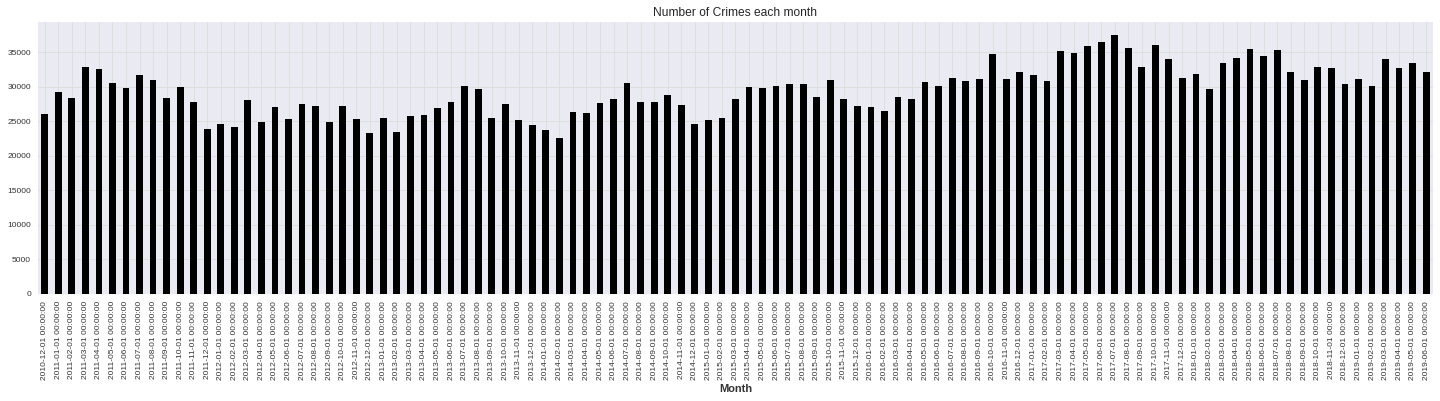

In [20]:
import pandas as pd

manchester_analytics.plot(kind= "bar",  figsize=(25, 5), title= "Number of Crimes each month")

manchester_analytics

In [21]:
import pandas as pd
from darts import TimeSeries

series = TimeSeries.from_series(manchester_analytics)

series

<TimeSeries (DataArray) (Month: 103, component: 1, sample: 1)>
array([[[25968.]],

       [[29267.]],

       [[28319.]],

       [[32842.]],

       [[32551.]],

       [[30476.]],

       [[29774.]],

       [[31621.]],

       [[30901.]],

       [[28342.]],

...

       [[30956.]],

       [[32838.]],

       [[32672.]],

       [[30377.]],

       [[31063.]],

       [[30117.]],

       [[33936.]],

       [[32703.]],

       [[33386.]],

       [[32058.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 2010-12-01 2011-01-01 ... 2019-06-01
  * component  (component) object 'Count'
Dimensions without coordinates: sample

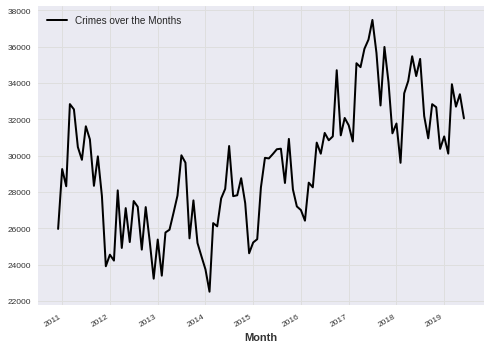

In [25]:
series.plot(label="Crimes over the Months")

In [53]:
train, val = series[:-20], series[-30:]
train

<TimeSeries (DataArray) (Month: 113, component: 1, sample: 1)>
array([[[11194.]],

       [[12188.]],

       [[12404.]],

       [[14533.]],

       [[15217.]],

       [[13457.]],

       [[13068.]],

       [[13854.]],

       [[14136.]],

       [[11627.]],

...

       [[14534.]],

       [[14405.]],

       [[13350.]],

       [[15523.]],

       [[14060.]],

       [[12743.]],

       [[13534.]],

       [[13195.]],

       [[13735.]],

       [[13650.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 2010-12-01 2011-01-01 ... 2020-04-01
  * component  (component) object 'Count'
Dimensions without coordinates: sample

In [28]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

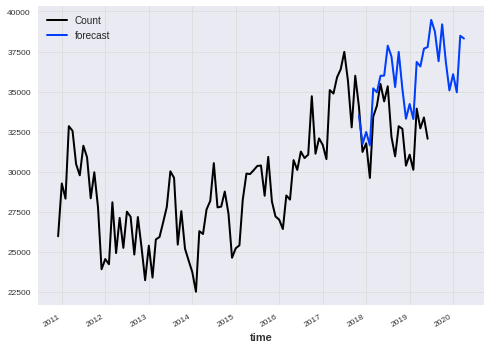

In [29]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.5, high_quantile=0.5)
plt.legend()

## Dorset County

In [30]:
dorset = pandas_data.loc[pandas_data['Falls within'] == "Dorset Police"] 	

In [32]:
# profile = ProfileReport(dorset, title="Dorset Police Profiling Report", explorative=True)
# profile

In [33]:
dorset_crime_count = dorset.groupby(["Month"]).size()
dorset_crime_count_reset = dorset_crime_count.reset_index()
dorset_crime_count_reset.rename(columns = {0:'Count'}, inplace = True)

dorset_crime_count_reset['Month'] = pd.to_datetime(dorset_crime_count_reset['Month'])

dorset_analytics = dorset_crime_count_reset.groupby(by = "Month").Count.mean()
dorset_analytics

Month
2010-12-01    6190.0
2011-01-01    3187.0
2011-02-01    6647.0
2011-03-01    7273.0
2011-04-01    7495.0
               ...  
2021-08-01    6099.0
2021-09-01    5957.0
2021-10-01    5715.0
2021-11-01    5575.0
2021-12-01    5039.0
Name: Count, Length: 133, dtype: float64

Month
2010-12-01    6190.0
2011-01-01    3187.0
2011-02-01    6647.0
2011-03-01    7273.0
2011-04-01    7495.0
               ...  
2021-08-01    6099.0
2021-09-01    5957.0
2021-10-01    5715.0
2021-11-01    5575.0
2021-12-01    5039.0
Name: Count, Length: 133, dtype: float64

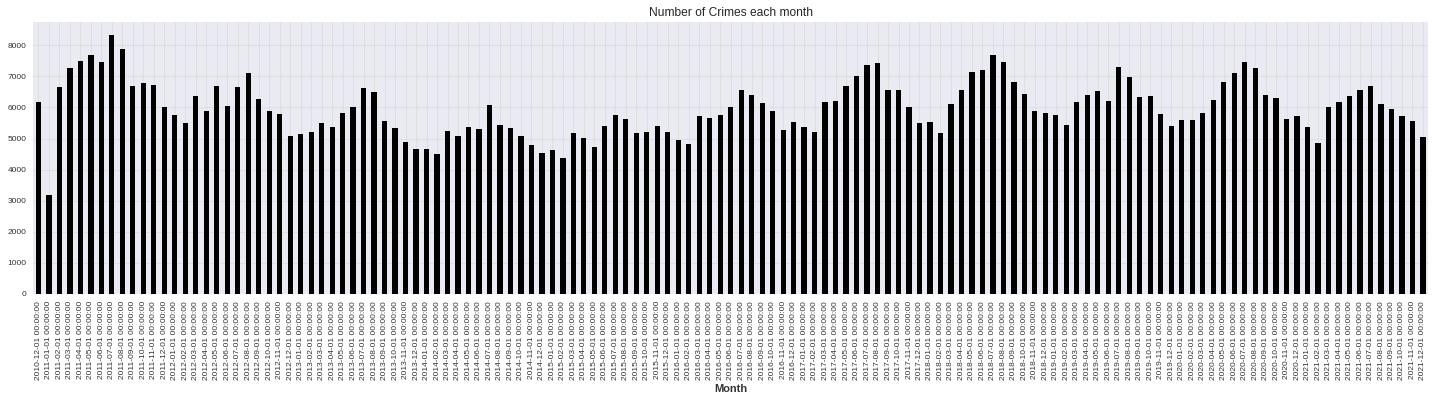

In [34]:
import pandas as pd

dorset_analytics.plot(kind= "bar",  figsize=(25, 5), title= "Number of Crimes each month")

dorset_analytics

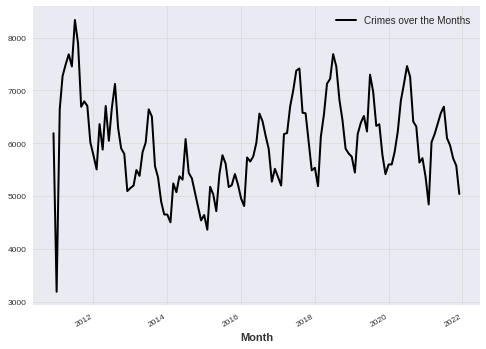

In [35]:
import pandas as pd
from darts import TimeSeries

series = TimeSeries.from_series(dorset_analytics)

series

series.plot(label="Crimes over the Months")

In [36]:
train, val = series[:-20], series[-30:]
val

from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

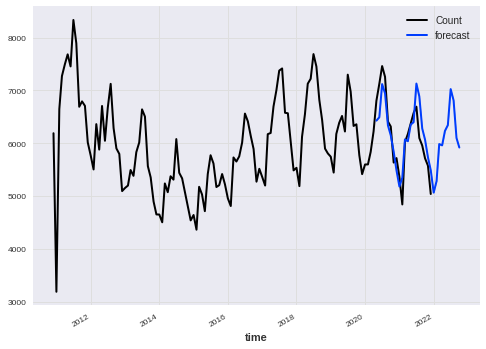

In [37]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.5, high_quantile=0.5)
plt.legend()

## Merseyside

In [38]:
merseyside = pandas_data.loc[pandas_data['Falls within'] == "Merseyside Police"] ##Merseyside Police	

In [40]:
merseyside_crime_count = merseyside.groupby(["Month"]).size()
merseyside_crime_count_reset = merseyside_crime_count.reset_index()
merseyside_crime_count_reset.rename(columns = {0:'Count'}, inplace = True)

merseyside_crime_count_reset['Month'] = pd.to_datetime(merseyside_crime_count_reset['Month'])

merseyside_analytics = merseyside_crime_count_reset.groupby(by = "Month").Count.mean()
merseyside_analytics

Month
2010-12-01    11194.0
2011-01-01    12188.0
2011-02-01    12404.0
2011-03-01    14533.0
2011-04-01    15217.0
               ...   
2021-08-01    15568.0
2021-09-01    15901.0
2021-10-01    16600.0
2021-11-01    15875.0
2021-12-01    14018.0
Name: Count, Length: 133, dtype: float64

Month
2010-12-01    11194.0
2011-01-01    12188.0
2011-02-01    12404.0
2011-03-01    14533.0
2011-04-01    15217.0
               ...   
2021-08-01    15568.0
2021-09-01    15901.0
2021-10-01    16600.0
2021-11-01    15875.0
2021-12-01    14018.0
Name: Count, Length: 133, dtype: float64

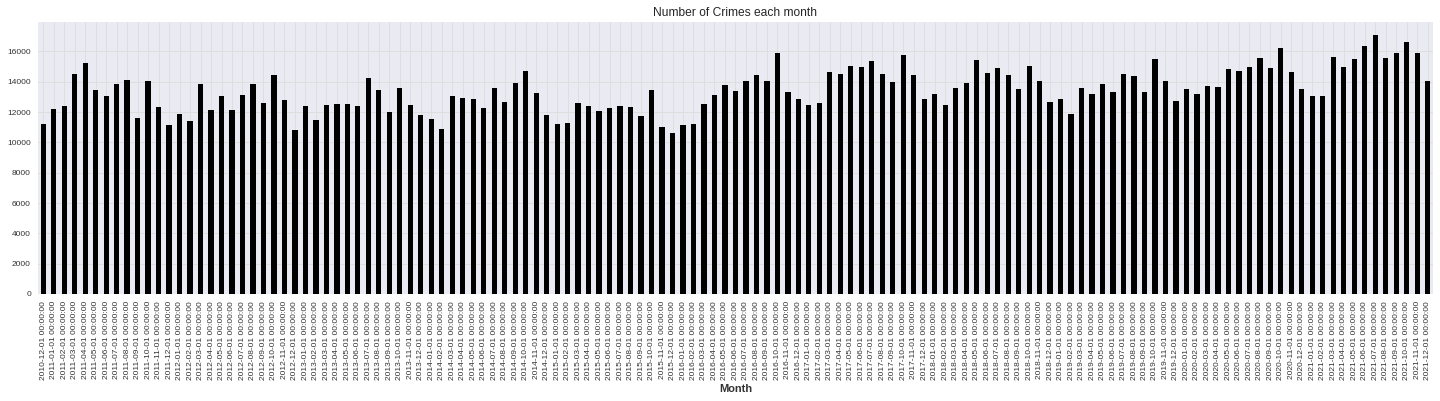

In [48]:
import pandas as pd


merseyside_analytics.plot(kind= "bar",  figsize=(25, 5), title= "Number of Crimes each month")

merseyside_analytics

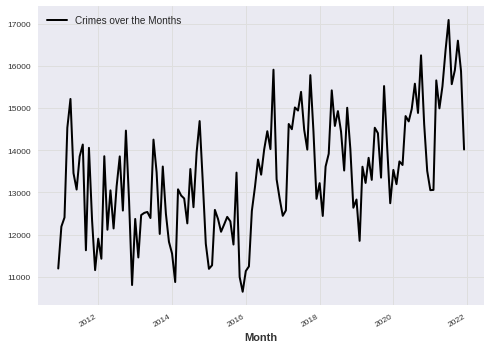

In [42]:
import pandas as pd
from darts import TimeSeries

series = TimeSeries.from_series(merseyside_analytics)

series

series.plot(label="Crimes over the Months")

In [43]:
train, val = series[:-20], series[-30:]
val

<TimeSeries (DataArray) (Month: 30, component: 1, sample: 1)>
array([[[14534.]],

       [[14405.]],

       [[13350.]],

       [[15523.]],

       [[14060.]],

       [[12743.]],

       [[13534.]],

       [[13195.]],

       [[13735.]],

       [[13650.]],

...

       [[15657.]],

       [[14994.]],

       [[15516.]],

       [[16378.]],

       [[17091.]],

       [[15568.]],

       [[15901.]],

       [[16600.]],

       [[15875.]],

       [[14018.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 2019-07-01 2019-08-01 ... 2021-12-01
  * component  (component) object 'Count'
Dimensions without coordinates: sample

In [44]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

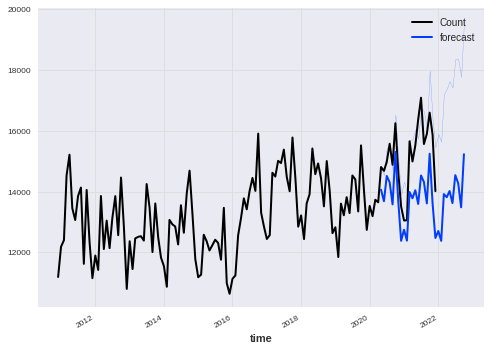

In [47]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.90, high_quantile=0.90)
plt.legend()